In [1]:
import qiskit
import qc_grader
print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.1.1
Grader version: 0.22.12


In [3]:
# Import common packages first
import numpy as np
from math import comb
import warnings
import pyscf
import matplotlib.pyplot as plt
import pickle
from functools import partial

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# Import qiskit ecosystems
import ffsim
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime import SamplerOptions

# Import grader
from qc_grader.challenges.qgss_2025 import (
    grade_lab3_ex1, 
    grade_lab3_ex2, 
    grade_lab3_ex3,
    grade_lab3_ex4,
    grade_lab3_ex5
)

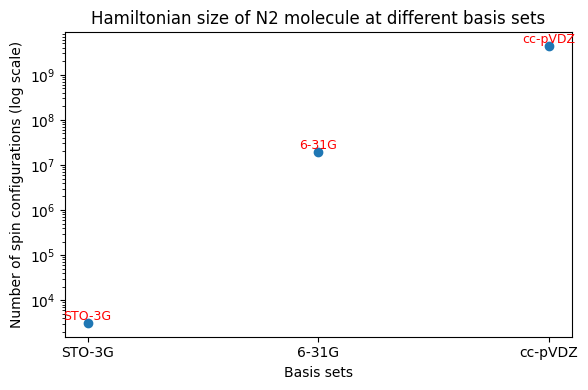

In [4]:
# Number of possible spin configurations
# Example: N2 molecule in STO-3G, 6-31G, and cc-pVDZ basis sets
# 14 electrons, 20 spin orbitals (from 10 spatial orbitals × 2)

# Calculate total electron configurations for each basis set
y1 = comb(8, 5) * comb(8, 5)       # STO-3G
y2 = comb(16, 5) * comb(16, 5)     # 6-31G
y3 = comb(26, 5) * comb(26, 5)     # cc-pVDZ

# Data
y = [y1, y2, y3]
x = list(range(len(y)))
labels = ['STO-3G', '6-31G', 'cc-pVDZ']

# Plot with logarithmic y-scale
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'o')

plt.yscale('log')
plt.xticks(x, labels)
plt.xlabel('Basis sets')
plt.ylabel('Number of spin configurations (log scale)')
plt.title('Hamiltonian size of N2 molecule at different basis sets')

# Add labels above points
for i in range(len(x)):
    plt.text(x[i], y[i], f'{labels[i]}', fontsize=9, ha='center', va='bottom', color='red')

plt.tight_layout()
plt.show()

In [5]:
import math

spin_orbitals = 16
alpha_electrons = 7
beta_electrons = 5

alpha_config = math.comb(spin_orbitals, alpha_electrons)
beta_config  = math.comb(spin_orbitals, beta_electrons)
total_config = alpha_config * beta_config

print(f"Total physical configurations for O2 in the given basis : {alpha_config} x {beta_config} = {total_config}")
grade_lab3_ex1(total_config)  # Verify with your grader


Total physical configurations for O2 in the given basis : 11440 x 4368 = 49969920
Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [6]:


warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot



converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


In [7]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929733  E_corr = -0.20458912219883


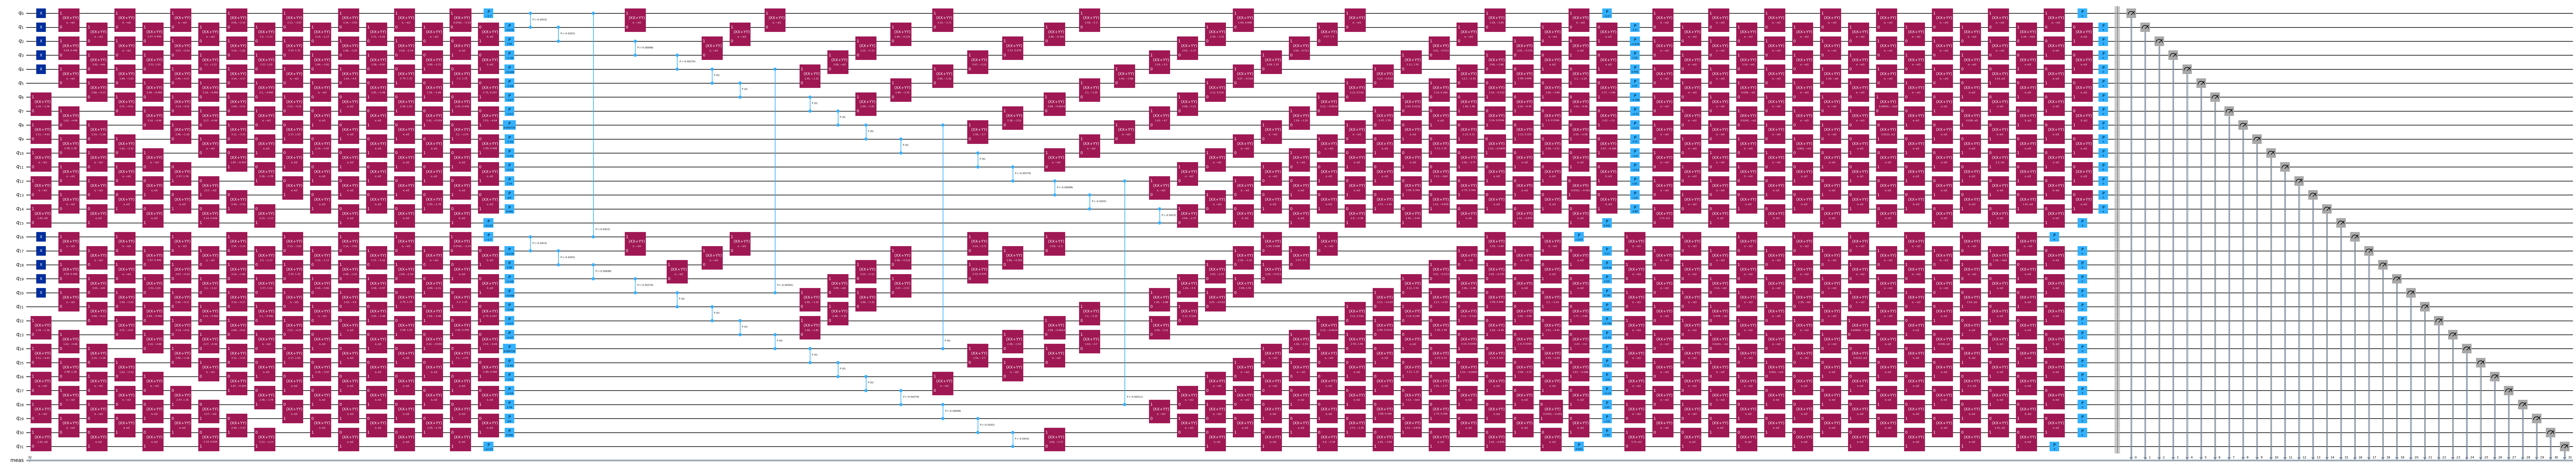

In [8]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

circuit.decompose().decompose().draw("mpl", fold =-1)


In [9]:
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend("ibm_brisbane")

In [10]:
spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")


Gate counts (w/ pre-init passes): OrderedDict({'rz': 2442, 'sx': 2157, 'ecr': 730, 'x': 78, 'measure': 32, 'barrier': 1})


In [11]:
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# sampler = Sampler(mode=backend)
# job = sampler.run([isa_circuit], shots=10_000)
# primitive_result = job.result()
# pub_result = primitive_result[0]
# bit_array = pub_result.data.meas

bit_array = np.load('utils/N2_device_bitarray.npy', allow_pickle=True).item()

In [12]:
%%time
# SQD options
energy_tol = 1e-3  
occupancies_tol = 1e-3 
max_iterations = 5

# Eigenstate solver options
num_batches = 5
samples_per_batch = 50
symmetrize_spin = True 
carryover_threshold = 1e-4 
max_cycle = 200
rng = np.random.default_rng(24)


# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)


# List to capture intermediate results
result_history = [] 

def callback(results: list[SCIResult]): 
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)



Iteration 1
	Subsample 0
		Energy: -106.27329013141704
		Subspace dimension: 10000
	Subsample 1
		Energy: -105.43810831755815
		Subspace dimension: 9801
	Subsample 2
		Energy: -106.6376942596939
		Subspace dimension: 10000
	Subsample 3
		Energy: -106.61258013830131
		Subspace dimension: 9801
	Subsample 4
		Energy: -106.63164450395638
		Subspace dimension: 9801
Iteration 2
	Subsample 0
		Energy: -107.91084907411823
		Subspace dimension: 9409
	Subsample 1
		Energy: -108.84006034736296
		Subspace dimension: 9604
	Subsample 2
		Energy: -108.84150457670022
		Subspace dimension: 10000
	Subsample 3
		Energy: -107.91290084871602
		Subspace dimension: 9409
	Subsample 4
		Energy: -108.84031227231546
		Subspace dimension: 9216
Iteration 3
	Subsample 0
		Energy: -108.89577578545787
		Subspace dimension: 12769
	Subsample 1
		Energy: -108.87738057039107
		Subspace dimension: 12769
	Subsample 2
		Energy: -108.88243139571694
		Subspace dimension: 12321
	Subsample 3
		Energy: -108.86232234859597
		Subs

In [13]:
def plot_energy_and_occupancy(result_history, exact_energy):

    # Data for energies plot
    x1 = range(len(result_history))
    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    e_diff = [abs(e - exact_energy) for e in min_e]
    yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
    
    # Chemical accuracy (+/- 1 milli-Hartree)
    chem_accuracy = 0.001
    
    # Data for avg spatial orbital occupancy
    y2 = np.sum(result.orbital_occupancies, axis=0)
    x2 = range(len(y2))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot energies
    axs[0].plot(x1, e_diff, label="energy error", marker="o")
    axs[0].set_xticks(x1)
    axs[0].set_xticklabels(x1)
    axs[0].set_yticks(yt1)
    axs[0].set_yticklabels(yt1)
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-4)
    axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
    axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
    axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
    axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
    axs[0].legend()
    
    # Plot orbital occupancy
    axs[1].bar(x2, y2, width=0.8)
    axs[1].set_xticks(x2)
    axs[1].set_xticklabels(x2)
    axs[1].set_title("Avg Occupancy per Spatial Orbital")
    axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
    axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
    
    print(f"Exact energy: {exact_energy:.5f} Ha")
    print(f"SQD energy: {min_e[-1]:.5f} Ha")
    print(f"Absolute error: {e_diff[-1]:.5f} Ha")
    plt.tight_layout()
    plt.show()



Exact energy: -109.04667 Ha
SQD energy: -108.96882 Ha
Absolute error: 0.07785 Ha


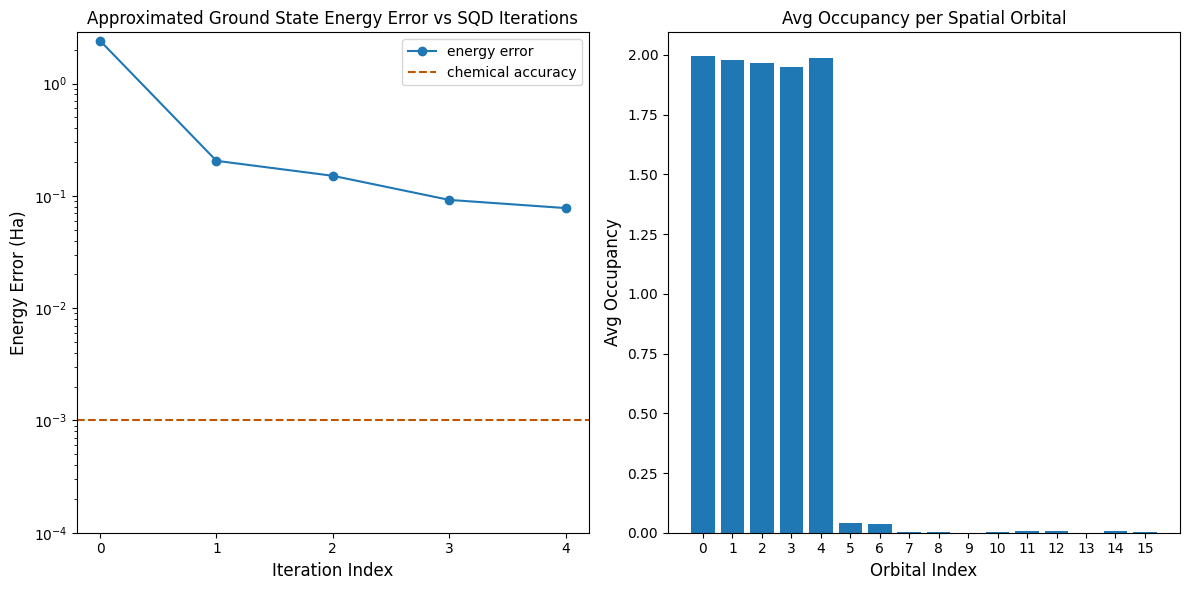

In [14]:
plot_energy_and_occupancy(result_history, exact_energy)


In [15]:
import numpy as np

n = [0.007, 0.029, 0.029, 0.995, 
     0.976, 0.976, 0.993, 0.997, 
     0.007, 0.029, 0.029, 0.995,
     0.976, 0.976, 0.993, 0.997]

x = [1, 0, 0, 0,  1, 0, 1, 1,  1, 0, 1, 1,  1, 1, 0, 0]

x = np.array(x)
n = np.array(n)

# ---- TODO : Task 2 ---

# Divide into alpha and beta spin (as per the note: "right half spin-up, left half spin-down")
# Left half: beta (first 8), right half: alpha (last 8)
x_beta = x[:8]
x_alpha = x[8:]
n_beta = n[:8]
n_alpha = n[8:]

# Probability of flipping
y_alpha = np.abs(x_alpha - n_alpha)
y_beta = np.abs(x_beta - n_beta)

# In this case, one more beta particle is needed, so if x_beta[i] is already 1, set y_beta[i] to 0
for i in range(len(y_beta)):
    if x_beta[i] == 1:
        y_beta[i] = 0

# Weighted flipping probability for beta
h = 5/8
delta = 0.01
w = np.zeros(len(y_beta))

for i in range(len(y_beta)):
    y = y_beta[i]
    if y <= h:
        w[i] = delta * (y / h)
    else:
        w[i] = delta + (1 - delta) * ((y - h) / (1 - h))

# Find the index with the maximum w
max_index = np.argmax(w)
max_w = w[max_index]

# Flip the bit of that index in x_beta
corrected_x_beta = np.copy(x_beta)
corrected_x_beta[max_index] = 1 - corrected_x_beta[max_index]

# Reconstruct the bitstring as [beta | alpha]
corrected_x = np.concatenate([corrected_x_beta, x_alpha])

# --- End of TODO ---

# For debugging:
# print("y_beta:", y_beta)
# print("w:", w)
# print("max_index:", max_index, "max_w:", max_w)
# print("original x:", x)
# print("corrected_x:", corrected_x)

# Submit your answer using following code
grade_lab3_ex2(corrected_x.tolist())


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [16]:
warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    # ---- TODO : Task 3 ---
    basis='cc-pvdz',  ### input your code here ###
    # --- End of TODO ---
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

print(num_orbitals)

# ---- TODO : Task 3 ---
n_qubits = 2 * num_orbitals + 6  ### input your result ###
# --- End of TODO ---

# Submit your answer using following code
grade_lab3_ex3(n_qubits) # Expected result type: integer


converged SCF energy = -108.92983838561
26
Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [17]:
backend = service.backend('ibm_torino') 

In [18]:
import qiskit
print(f'Qiskit: {qiskit.__version__}')


Qiskit: 2.1.1


In [19]:
with open("utils/backend_target_v21.pkl", "rb") as f:
    backend_target = pickle.load(f)


In [20]:
BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_CZGATE_ERROR_THRESHOLD = 0.1
backend_num_qubits = 133

# ---- TODO : Task 4 ---
bad_readout_qubits = [
    q for q in range(backend_num_qubits)
    if backend_target["measure"][(q,)].error >= BAD_READOUT_ERROR_THRESHOLD
]
bad_czgate_edges = [
    edge for edge in backend_target.build_coupling_map().get_edges()
    if backend_target["cz"][edge].error >= BAD_CZGATE_ERROR_THRESHOLD
]
# --- End of TODO ---

print("Bad readout qubits:", bad_readout_qubits)
print("Bad CZ gates:", bad_czgate_edges)


Bad readout qubits: [12, 53, 115, 126, 131]
Bad CZ gates: [(100, 101), (101, 100)]


In [21]:
# ---- TODO : Task 4 ---
spin_a_layout = [2,3,4,16,23,24,25,35,44,45,46,55,65,66,67,74,86,87,88,94,107,108,109,113,128,127]
spin_b_layout = [0,15,19,20,21,34,40,41,42,54,61,62,63,73,82,83,84,93,103,104,105,112,124,123,122,121]
# --- End of TODO ---

initial_layout = spin_a_layout + spin_b_layout

# Verify correct length
assert len(spin_a_layout) == len(spin_b_layout) == 26, "wrong length"

# Submit your answer
grade_lab3_ex4(initial_layout) # Expected result type: list


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [25]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

n_reps = 1

# ---- TODO : Task 5 ---
import itertools

num_orbitals = 26 
# 1. Identify the alpha spin orbitals (every 4th index).
alpha_orbitals = list(range(0, num_orbitals, 4))
num_alpha_orbitals = len(alpha_orbitals)

# 2. Generate all possible unique pairs (i, j) where i < j.
all_pairs = list(itertools.combinations(alpha_orbitals, 2))

alpha_alpha_indices = []
for p in range(num_orbitals-2):
    alpha_alpha_indices.append((p,p+1))
alpha_alpha_indices.append((num_orbitals-2,num_orbitals-1))
for p in range(num_orbitals-2):
    alpha_alpha_indices.append((p,p+2))

# --- End of TODO ---

# Sort the list for a canonical representation.
#alpha_alpha_indices.sort()
# --- End of TODO ---

# Define the alpha-beta interaction pairs.
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

# Create the UCJ operator with the correctly defined interaction pairs.
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

# Set up the rest of the circuit simulation.
nelec = (num_elec_a, num_elec_b)
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()
circuit.decompose().decompose().draw("mpl", fold=-1)

# Submit your answer to the grader.
grade_lab3_ex5(alpha_alpha_indices)



E(CCSD) = -109.2177884185545  E_corr = -0.2879500329450033
Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [26]:
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 2/2 exercises completed (100%)
    ✅ 2178 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 1594 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 857 participants have completed this lab
Lab 3: 5/5 exercises completed (100%)
    ✅ 585 participants have completed this lab
Lab 4: 0/6 exercises completed (0%)
    ✅ 344 participants have completed this lab
Functions Labs: 0/8 exercises completed (0%)
    ✅ 2 participants have completed this lab
